In [191]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
sns.set_theme()

In [192]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [193]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [194]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [196]:
# Única fila con valores nulos.
df[df["dropoff_longitude"].isna()]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,32736015,2013-07-02 03:51:57.0000001,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


In [197]:
df.duplicated().values.any()

np.False_

In [198]:
df.isna().values.any()

np.True_

In [199]:
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [200]:
# Función para calcular la distancia del viaje en base a las coordenadas 
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [201]:
# Función para asignar la franja horaria
def obtener_franja_horaria(hora):
    if 0 <= hora <= 5:
        return 'Madrugada'
    elif 6 <= hora <= 9:
        return 'Mañana'
    elif 10 <= hora <= 15:
        return 'Mediodia/Tarde'
    elif 16 <= hora <= 19:
        return 'Tarde'
    else:
        return 'Noche'

In [202]:
def obtener_semana_mes(fecha):
    return min(int(np.ceil(fecha.day / 7)), 4)

In [203]:
# Creación de copia del df para evitar conflictos.
df_copy = df.copy()

Se aprecian valores atípicos muy alejados de la media de los datos y valores negativos imposibles.

<Axes: ylabel='fare_amount'>

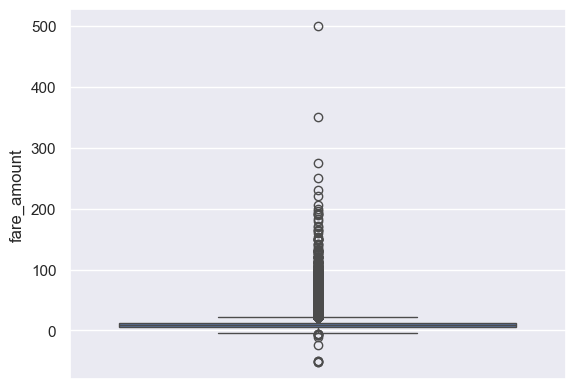

In [204]:
sns.boxplot(df_copy["fare_amount"])

In [205]:
# Eliminación de único valor atípico en la cantidad de pasajeros 
df_copy = df_copy[df_copy["passenger_count"] < 7]


In [206]:
# Filas con precios atípicos
df_copy[df_copy["fare_amount"] > 250]

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4292,33491441,2014-10-24 20:20:00.000000181,350.0,2014-10-24 20:20:00 UTC,0.000000,0.000000,0.000000,0.0000,3
170081,51151143,2011-04-10 04:10:00.00000064,499.0,2011-04-10 04:10:00 UTC,-73.968377,40.764602,-73.968368,40.7646,1
185325,20013003,2013-04-19 00:00:00.000000235,275.0,2013-04-19 00:00:00 UTC,0.000000,0.000000,0.000000,0.0000,1


In [207]:
df_copy = df_copy[df_copy["fare_amount"] < 250] 

In [208]:
df_copy["fare_amount"].describe()

count    199995.000000
mean         11.353311
std           9.780229
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         230.000000
Name: fare_amount, dtype: float64

Eliminación de filas con precio negativo. 

In [209]:
df_copy = df_copy[df_copy["fare_amount"] > 0]

In [210]:
# Conversión de tipo de datos y creación de columnas. 
df_copy["passenger_count"] = df_copy["passenger_count"].astype("Int64")
df_copy['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


In [211]:
df_copy.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [212]:
df_copy['dia_semana'] = df_copy['pickup_datetime'].dt.weekday
n = 7
df_copy["dia_sin"] = np.sin(2 * np.pi * df_copy["dia_semana"] / n)
df_copy["dia_cos"] = np.cos(2 * np.pi * df_copy["dia_semana"] / n)

In [213]:
df_copy.drop(columns=["dia_semana"], inplace=True)

In [214]:
df_copy["distance_km"] = haversine(
    df_copy["pickup_latitude"], df_copy["pickup_longitude"],
    df_copy["dropoff_latitude"], df_copy["dropoff_longitude"]
)

In [215]:
# Eliminacióin de columna redundante, igual que pickup_datetime
df_copy = df_copy.drop("date",axis=1)

In [216]:
# Aplicar la función a la columna de la hora para crear la nueva variable categórica
df_copy['franja_horaria'] = df_copy['pickup_datetime'].dt.hour.apply(obtener_franja_horaria)

In [217]:
df_copy["semana_mes"] = df_copy["pickup_datetime"].apply(obtener_semana_mes)

In [218]:
df_copy.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria,semana_mes
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.433884,-0.900969,1.683323,Tarde,1
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,-0.433884,-0.900969,2.457590,Noche,3
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.000000,1.000000,5.036377,Noche,4
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,-0.433884,-0.900969,1.661683,Mañana,4
4,17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.433884,-0.900969,4.475450,Tarde,4


In [219]:
df_copy["semana_mes"].value_counts()

semana_mes
4    60586
2    47367
3    47255
1    44765
Name: count, dtype: int64

In [220]:
# Creación de dummies en columna franja horaria
encoder = OneHotEncoder(sparse_output=False, drop='first')  

encoded = encoder.fit_transform(df_copy[['franja_horaria','semana_mes']])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['franja_horaria','semana_mes']))

df_encoded = pd.concat([df_copy.drop(columns=['franja_horaria','semana_mes']), encoded_df], axis=1)

df_encoded.head()


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4
0,24238194.0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.433884,-0.900969,1.683323,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,27835199.0,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,-0.433884,-0.900969,2.457590,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,44984355.0,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.000000,1.000000,5.036377,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,25894730.0,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,-0.433884,-0.900969,1.661683,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,17610152.0,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.433884,-0.900969,4.475450,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [221]:
cols_dummies = [c for c in df_encoded.columns if c.startswith("franja_horaria_") or c.startswith("semana_mes_")]
df_encoded[cols_dummies] = df_encoded[cols_dummies].astype('Int32')

In [222]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 197172
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   key                            199973 non-null  float64            
 1   fare_amount                    199973 non-null  float64            
 2   pickup_datetime                199973 non-null  datetime64[ns, UTC]
 3   pickup_longitude               199973 non-null  float64            
 4   pickup_latitude                199973 non-null  float64            
 5   dropoff_longitude              199972 non-null  float64            
 6   dropoff_latitude               199972 non-null  float64            
 7   passenger_count                199973 non-null  Int64              
 8   dia_sin                        199973 non-null  float64            
 9   dia_cos                        199973 non-null  float64            
 10  distance_km  

In [223]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='fare_amount'), df_encoded['fare_amount'], test_size=0.2, random_state=42)

In [224]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 153266 to 121972
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   key                            159976 non-null  float64            
 1   pickup_datetime                159976 non-null  datetime64[ns, UTC]
 2   pickup_longitude               159976 non-null  float64            
 3   pickup_latitude                159976 non-null  float64            
 4   dropoff_longitude              159975 non-null  float64            
 5   dropoff_latitude               159975 non-null  float64            
 6   passenger_count                159976 non-null  Int64              
 7   dia_sin                        159976 non-null  float64            
 8   dia_cos                        159976 non-null  float64            
 9   distance_km                    159975 non-null  float64            
 10  franja_h

In [225]:
# Eliminación de única fila con nulos
X_train.dropna(inplace=True)

In [226]:
X_train.sample(10)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4
80686,7873270.0,2013-03-29 22:19:00+00:00,-73.991997,40.743747,-73.973157,40.756667,1,-0.433884,-0.900969,2.140698,1,0,0,0,0,1,0
157455,52198894.0,2010-07-06 08:12:34+00:00,-73.980349,40.770311,-73.977509,40.753881,1,0.781831,0.623490,1.842524,0,1,0,0,0,0,0
187175,35015773.0,2009-11-13 00:38:00+00:00,-73.983319,40.762894,-73.889141,40.758955,2,-0.433884,-0.900969,7.944088,0,0,0,1,0,1,0
182605,39323171.0,2011-07-29 11:51:00+00:00,-74.019487,40.772368,-74.054130,40.764170,1,-0.433884,-0.900969,3.056532,0,0,0,0,1,0,0
32784,44173349.0,2012-01-12 14:00:02+00:00,-74.001835,40.719561,-73.979732,40.762297,1,0.433884,-0.900969,5.103858,0,0,0,1,1,0,0
81184,28685709.0,2011-03-25 14:35:05+00:00,-73.956656,40.817970,-73.991040,40.750317,2,-0.433884,-0.900969,8.060471,1,0,0,0,0,1,0
113172,19230534.0,2010-10-25 06:22:00+00:00,-73.991218,40.745383,-73.861842,40.768458,1,0.000000,1.000000,11.195157,0,0,0,0,0,1,0
87555,8040528.0,2014-04-15 03:58:21+00:00,-73.981642,40.773729,-73.981646,40.721268,1,0.781831,0.623490,5.833397,0,1,0,0,0,0,1
95392,22256021.0,2013-03-19 15:58:00+00:00,-73.979357,40.752607,-73.980822,40.738205,1,0.781831,0.623490,1.606178,0,1,0,0,0,0,0
54122,34967749.0,2013-11-11 21:46:00+00:00,-73.958740,40.778387,-73.990375,40.751627,3,0.000000,1.000000,3.994029,0,0,1,0,0,0,1


In [227]:
X_train[X_train["distance_km"] == 0]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4
179569,13604404.0,2012-01-02 19:24:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0.000000,1.000000,0.0,0,0,0,1,0,0,0
74481,42591482.0,2010-07-03 03:48:00+00:00,0.000000,0.000000,0.000000,0.000000,1,-0.974928,-0.222521,0.0,0,1,0,0,0,1,0
148588,17659910.0,2014-02-11 11:56:00+00:00,0.000000,0.000000,0.000000,0.000000,3,0.781831,0.623490,0.0,0,0,1,0,0,1,0
165366,7323405.0,2012-10-20 10:43:10+00:00,0.000000,0.000000,0.000000,0.000000,1,-0.974928,-0.222521,0.0,0,0,0,1,0,0,0
45908,31524124.0,2011-03-03 09:25:40+00:00,-73.969795,40.771058,-73.969795,40.771058,1,0.433884,-0.900969,0.0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12667,50739849.0,2009-03-06 13:13:41+00:00,0.000000,0.000000,0.000000,0.000000,1,-0.433884,-0.900969,0.0,0,0,0,1,0,0,1
124389,46970688.0,2014-11-12 17:52:11+00:00,0.000000,0.000000,0.000000,0.000000,1,0.974928,-0.222521,0.0,0,1,0,0,1,0,0
139658,10670628.0,2013-05-27 21:16:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0.000000,1.000000,0.0,1,0,0,0,0,0,1
197656,8665170.0,2012-04-09 17:43:00+00:00,0.000000,0.000000,0.000000,0.000000,1,0.000000,1.000000,0.0,0,0,1,0,0,0,0


In [228]:
# Valores atípicos pero posibles dentro de NY y en sus cercanías
X_train[(X_train["distance_km"] > 150) & (X_train["distance_km"] < 250)]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4
24751,1200661.0,2011-02-17 18:30:35+00:00,-75.426904,40.774075,-73.971779,39.622013,1,0.433884,-0.900969,177.995633,0,0,1,0,0,1,0
197483,34261866.0,2011-05-09 13:41:53+00:00,-75.342288,40.646767,-73.976186,39.615770,1,0.000000,1.000000,163.187094,1,0,0,0,0,0,1


In [229]:
X_train[(X_train["distance_km"] > 250)]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4
81071,34750198.0,2011-08-17 10:04:00+00:00,0.000000,0.000000,-73.974373,40.743265,1,0.974928,-0.222521,8665.071975,0,0,0,1,0,0,0
190692,50642087.0,2013-05-10 09:57:00+00:00,-0.021667,0.000000,-73.975897,40.749252,1,-0.433884,-0.900969,8663.526930,0,1,0,0,1,0,0
65616,22191833.0,2013-03-23 20:58:00+00:00,-73.987972,40.727948,0.000000,40.746405,1,-0.974928,-0.222521,6032.397864,0,1,0,0,1,0,0
73585,1170025.0,2014-10-04 15:11:08+00:00,-73.968760,40.761391,0.000000,0.000000,1,-0.974928,-0.222521,8664.978773,1,0,0,0,0,0,1
145647,48568090.0,2012-06-06 22:06:00+00:00,0.000000,0.000000,-73.991548,40.727385,1,0.974928,-0.222521,8666.169202,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35740,46898673.0,2013-11-06 16:50:08+00:00,-73.987819,40.738399,0.000000,0.000000,1,0.974928,-0.222521,8666.085761,0,0,0,1,0,1,0
154800,16463213.0,2015-06-15 08:07:41+00:00,-73.996712,40.733402,0.000000,0.000000,1,0.000000,1.000000,8666.719980,0,0,0,1,0,0,0
58246,13199504.0,2013-08-26 18:04:00+00:00,-73.947277,40.805427,0.000000,40.802898,1,0.000000,1.000000,6022.748042,0,0,0,0,0,0,1
118338,47829179.0,2012-10-09 07:56:00+00:00,-74.004672,40.746927,0.000000,40.774267,2,0.781831,0.623490,6031.361768,0,0,0,1,0,0,1


In [230]:
coords = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
conteo_ceros = (df_copy[coords] == 0.0).sum(axis=1)
df_filtrado = df_copy[conteo_ceros > 2]
df_filtrado

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria,semana_mes
7,44195482,2.5,2012-12-11 13:52:00+00:00,0.0,0.0,0.0,0.0,1,0.781831,0.623490,0.0,Mediodia/Tarde,2
11,6379048,8.5,2011-05-23 22:15:00+00:00,0.0,0.0,0.0,0.0,1,0.000000,1.000000,0.0,Noche,4
65,21993993,6.0,2014-05-05 19:27:00+00:00,0.0,0.0,0.0,0.0,1,0.000000,1.000000,0.0,Tarde,1
92,1454546,6.1,2011-12-02 14:07:00+00:00,0.0,0.0,0.0,0.0,1,-0.433884,-0.900969,0.0,Mediodia/Tarde,1
120,17358122,6.5,2010-08-20 19:39:48+00:00,0.0,0.0,0.0,0.0,1,-0.433884,-0.900969,0.0,Tarde,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199718,49162936,4.9,2011-08-19 07:16:00+00:00,0.0,0.0,0.0,0.0,1,-0.433884,-0.900969,0.0,Mañana,3
199724,46007628,7.5,2013-10-11 11:25:41+00:00,0.0,0.0,0.0,0.0,1,-0.433884,-0.900969,0.0,Mediodia/Tarde,2
199880,35013970,6.5,2014-02-22 06:45:46+00:00,0.0,0.0,0.0,0.0,1,-0.974928,-0.222521,0.0,Mañana,4
199883,44115598,12.5,2012-09-10 17:39:00+00:00,0.0,0.0,0.0,0.0,2,0.000000,1.000000,0.0,Tarde,2


In [231]:
# Conversión de atípico a Nan para imputación futura 
X_train.loc[(X_train["distance_km"] > 250) | (X_train["distance_km"] == 0), "distance_km"] = np.nan

In [232]:
X_train.loc[X_train["passenger_count"] == 0, "passenger_count"] = np.nan

In [233]:
X_train.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dia_sin',
       'dia_cos', 'distance_km', 'franja_horaria_Mañana',
       'franja_horaria_Mediodia/Tarde', 'franja_horaria_Noche',
       'franja_horaria_Tarde', 'semana_mes_2', 'semana_mes_3', 'semana_mes_4'],
      dtype='object')

In [234]:
[c for c in X_train.columns if c != "pickup_datetime"]

['key',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'dia_sin',
 'dia_cos',
 'distance_km',
 'franja_horaria_Mañana',
 'franja_horaria_Mediodia/Tarde',
 'franja_horaria_Noche',
 'franja_horaria_Tarde',
 'semana_mes_2',
 'semana_mes_3',
 'semana_mes_4']

In [235]:
from sklearn.impute import KNNImputer


# Seleccionamos las columnas numéricas que queremos imputar
cols_to_impute = ["distance_km", "passenger_count"]

# Instanciamos el imputador
knn_imputer = KNNImputer(n_neighbors=5)

# Ajustamos y transformamos solo esas columnas
imputed = knn_imputer.fit_transform(X_train[cols_to_impute])

# Pasamos de nuevo a DataFrame
X_train[cols_to_impute] = pd.DataFrame(imputed, columns=cols_to_impute, index=X_train.index)


In [236]:
X_train["passenger_count"] = round(X_train["passenger_count"]).astype("Int64")

In [237]:
X_train["passenger_count"].value_counts()

passenger_count
1    110974
2     23752
5     11177
3      7140
4      3470
6      3440
Name: count, dtype: Int64

In [238]:
X_train["passenger_count"]

153266    1
67806     1
148905    1
103104    1
104693    1
         ..
119893    1
103705    1
131946    1
146882    1
121972    1
Name: passenger_count, Length: 159953, dtype: Int64

In [239]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159953 entries, 153266 to 121972
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   key                            159953 non-null  float64            
 1   pickup_datetime                159953 non-null  datetime64[ns, UTC]
 2   pickup_longitude               159953 non-null  float64            
 3   pickup_latitude                159953 non-null  float64            
 4   dropoff_longitude              159953 non-null  float64            
 5   dropoff_latitude               159953 non-null  float64            
 6   passenger_count                159953 non-null  Int64              
 7   dia_sin                        159953 non-null  float64            
 8   dia_cos                        159953 non-null  float64            
 9   distance_km                    159953 non-null  float64            
 10  franja_h

In [240]:
X_train.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dia_sin',
       'dia_cos', 'distance_km', 'franja_horaria_Mañana',
       'franja_horaria_Mediodia/Tarde', 'franja_horaria_Noche',
       'franja_horaria_Tarde', 'semana_mes_2', 'semana_mes_3', 'semana_mes_4'],
      dtype='object')

In [241]:
X_train[[column for column in X_train.columns if column != "key"]].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4
count,159953.000000,159953.000000,159953.000000,159953.000000,159953.0,159953.000000,159953.000000,159953.000000,159953.0,159953.0,159953.0,159953.0,159953.0,159953.0,159953.0
mean,-72.511936,39.915989,-72.503764,39.916260,1.68989,-0.001146,-0.043668,3.412573,0.14945,0.288654,0.219796,0.213632,0.235807,0.236713,0.303752
std,10.995888,6.319054,10.595907,6.284633,1.304622,0.711155,0.701681,4.008516,0.356533,0.453138,0.41411,0.409871,0.424503,0.425066,0.459878
min,-736.400000,-74.015515,-737.916665,-74.015750,1.0,-0.974928,-0.900969,0.000084,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-73.992050,40.734821,-73.991400,40.733747,1.0,-0.781831,-0.900969,1.306423,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-73.981819,40.752601,-73.980047,40.753057,1.0,0.000000,-0.222521,2.251513,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,-73.967127,40.767205,-73.963606,40.768048,2.0,0.781831,0.623490,4.181803,0.0,1.0,0.0,0.0,0.0,0.0,1.0
max,40.808425,404.433332,40.831932,493.533332,6.0,0.974928,1.000000,177.995633,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [242]:
# valores raros en cantidad de pasajeros 
X_train[X_train["passenger_count"] > 5]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4
92788,26498348.0,2012-12-06 19:26:00+00:00,-73.986807,40.745067,-74.004338,40.716647,6,0.433884,-0.900969,3.488367,0,0,0,1,0,0,1
154556,23023059.0,2013-12-08 20:20:00+00:00,-73.964902,40.761042,-73.974002,40.737397,6,-0.781831,0.623490,2.738675,0,0,0,1,0,1,0
114660,33773150.0,2014-02-21 00:41:00+00:00,-73.986900,40.741480,-73.952082,40.770767,6,-0.433884,-0.900969,4.382464,1,0,0,0,0,0,1
148210,11258368.0,2013-06-15 09:48:00+00:00,-73.964383,40.756347,-73.988342,40.751047,6,-0.974928,-0.222521,2.102419,0,0,1,0,0,1,0
188520,35499275.0,2012-12-10 17:09:00+00:00,-73.985342,40.744617,-73.979848,40.761262,6,0.000000,1.000000,1.907819,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183179,25443982.0,2015-04-04 12:18:35+00:00,-73.954086,40.790287,-73.981300,40.784248,6,-0.974928,-0.222521,2.387522,0,1,0,0,1,0,0
93436,49071202.0,2013-07-12 21:29:00+00:00,-74.001742,40.735327,-73.985133,40.741612,6,-0.433884,-0.900969,1.564149,0,1,0,0,0,0,0
113583,23602161.0,2012-07-19 23:17:00+00:00,-73.975222,40.761115,-73.971285,40.680927,6,0.433884,-0.900969,8.922670,0,1,0,0,0,0,1
2568,11585668.0,2012-04-07 23:11:00+00:00,-73.985683,40.731365,-73.992953,40.724337,6,-0.974928,-0.222521,0.992975,0,0,1,0,0,0,0


In [243]:
# Valores raros en columna de precios 
y_train[y_train > 150]

196647    200.00
188234    165.00
123996    152.83
127214    183.00
114282    190.83
184901    196.00
90818     163.00
131093    150.83
145249    160.00
53996     171.35
197493    230.00
23682     206.38
33911     192.33
45094     170.00
18415     190.00
39716     191.80
19509     180.00
Name: fare_amount, dtype: float64

In [244]:
# Valores atípicos en distancia(valores faltantes en lat/long)
X_train[X_train["distance_km"] > 60]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4
94979,12010769.0,2010-07-31 23:33:13+00:00,-73.137393,41.366138,-73.984311,40.720673,1,-0.974928,-0.222521,100.974360,0,1,0,0,0,1,0
21353,33456163.0,2010-05-03 11:45:32+00:00,-73.137393,41.366138,-74.006791,40.728763,1,0.000000,1.000000,101.676953,0,1,0,0,0,0,0
169786,54618564.0,2011-04-04 23:59:40+00:00,-75.419276,40.771689,-73.980900,40.764442,2,0.000000,1.000000,121.133501,1,0,0,0,0,0,1
151042,7139963.0,2011-03-31 21:04:21+00:00,-73.981823,40.773357,-73.938710,39.629385,1,0.433884,-0.900969,127.256551,0,1,0,0,0,1,0
113021,17184298.0,2011-05-05 07:15:20+00:00,-73.986632,40.761410,-75.423067,40.773931,2,0.433884,-0.900969,120.975971,0,0,1,0,1,0,0
79244,33480288.0,2009-07-14 10:19:06+00:00,-73.137393,41.366138,-73.988598,40.757339,1,0.781831,0.623490,98.364525,1,0,0,0,0,0,1
101692,53752103.0,2009-05-19 16:53:43+00:00,-73.985779,40.758935,-73.137393,41.366138,1,0.781831,0.623490,98.070305,0,1,0,0,1,0,0
94734,44686129.0,2011-03-04 15:08:06+00:00,-73.969908,40.762523,-73.952284,39.614156,1,-0.433884,-0.900969,127.701329,0,0,0,1,0,1,0
56185,22173897.0,2009-04-22 19:30:59+00:00,-73.137393,41.366138,-73.955553,40.776658,1,0.974928,-0.222521,94.869531,0,1,0,0,0,0,1
116191,10273216.0,2009-11-20 19:51:14+00:00,-73.964483,40.756388,-73.137393,41.366138,1,-0.433884,-0.900969,96.981946,0,1,0,0,0,0,0


<Axes: xlabel='distance_km', ylabel='Count'>

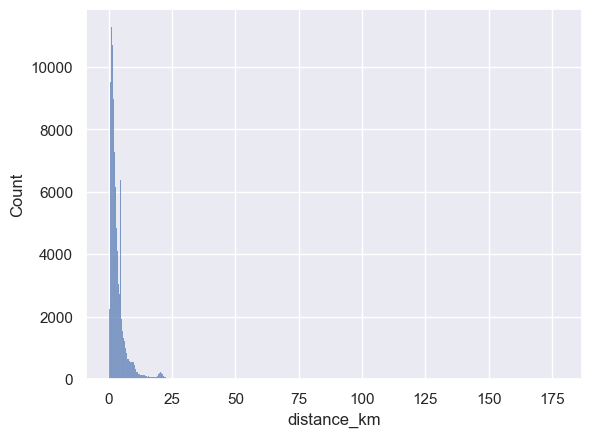

In [245]:
sns.histplot(X_train["distance_km"])

In [246]:
X_train["passenger_count"].value_counts().reset_index()

,passenger_count,count
0,1,110974
1,2,23752
2,5,11177
3,3,7140
4,4,3470
5,6,3440


<BarContainer object of 6 artists>

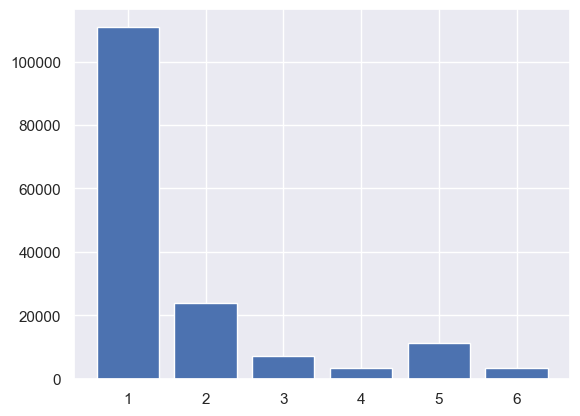

In [247]:
# sns.barplot(X_train["passenger_count"])
plt.bar(data = X_train["passenger_count"].value_counts().reset_index(),x = "passenger_count", height = "count",)

<Axes: xlabel='distance_km', ylabel='Count'>

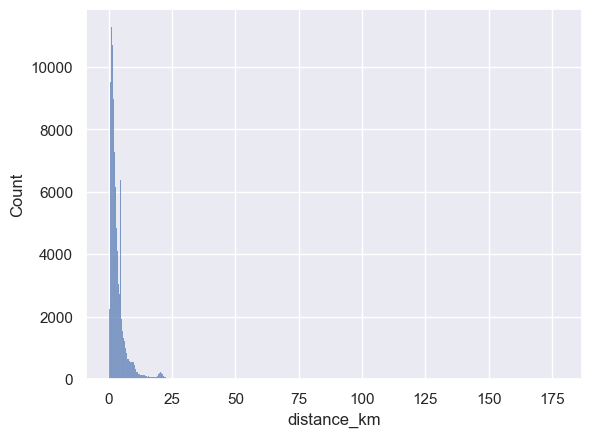

In [248]:
sns.histplot(X_train["distance_km"])

In [249]:
X_train.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dia_sin',
       'dia_cos', 'distance_km', 'franja_horaria_Mañana',
       'franja_horaria_Mediodia/Tarde', 'franja_horaria_Noche',
       'franja_horaria_Tarde', 'semana_mes_2', 'semana_mes_3', 'semana_mes_4'],
      dtype='object')

Observar luego de la imputación de datos atípicos. 

<Axes: >

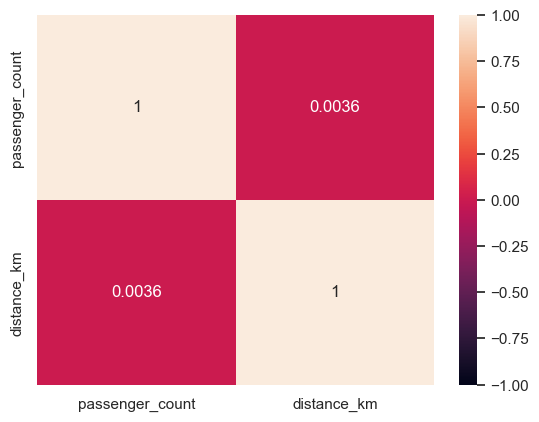

In [250]:
sns.heatmap(X_train[["passenger_count","distance_km"]].corr(),vmax=1,vmin=-1,annot=True)

In [251]:
X_train.describe()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dia_sin,dia_cos,distance_km,franja_horaria_Mañana,franja_horaria_Mediodia/Tarde,franja_horaria_Noche,franja_horaria_Tarde,semana_mes_2,semana_mes_3,semana_mes_4
count,1.599530e+05,159953.000000,159953.000000,159953.000000,159953.000000,159953.0,159953.000000,159953.000000,159953.000000,159953.0,159953.0,159953.0,159953.0,159953.0,159953.0,159953.0
mean,2.771163e+07,-72.511936,39.915989,-72.503764,39.916260,1.68989,-0.001146,-0.043668,3.412573,0.14945,0.288654,0.219796,0.213632,0.235807,0.236713,0.303752
std,1.600881e+07,10.995888,6.319054,10.595907,6.284633,1.304622,0.711155,0.701681,4.008516,0.356533,0.453138,0.41411,0.409871,0.424503,0.425066,0.459878
min,1.000000e+00,-736.400000,-74.015515,-737.916665,-74.015750,1.0,-0.974928,-0.900969,0.000084,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.382620e+07,-73.992050,40.734821,-73.991400,40.733747,1.0,-0.781831,-0.900969,1.306423,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2.776777e+07,-73.981819,40.752601,-73.980047,40.753057,1.0,0.000000,-0.222521,2.251513,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4.155270e+07,-73.967127,40.767205,-73.963606,40.768048,2.0,0.781831,0.623490,4.181803,0.0,1.0,0.0,0.0,0.0,0.0,1.0
max,5.542357e+07,40.808425,404.433332,40.831932,493.533332,6.0,0.974928,1.000000,177.995633,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [252]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159953 entries, 153266 to 121972
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   key                            159953 non-null  float64            
 1   pickup_datetime                159953 non-null  datetime64[ns, UTC]
 2   pickup_longitude               159953 non-null  float64            
 3   pickup_latitude                159953 non-null  float64            
 4   dropoff_longitude              159953 non-null  float64            
 5   dropoff_latitude               159953 non-null  float64            
 6   passenger_count                159953 non-null  Int64              
 7   dia_sin                        159953 non-null  float64            
 8   dia_cos                        159953 non-null  float64            
 9   distance_km                    159953 non-null  float64            
 10  franja_h

In [253]:
X_train.shape[0],X_test.shape[0]

(159953, 40000)

In [254]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 159953 entries, 153266 to 121972
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype              
---  ------                         --------------   -----              
 0   key                            159953 non-null  float64            
 1   pickup_datetime                159953 non-null  datetime64[ns, UTC]
 2   pickup_longitude               159953 non-null  float64            
 3   pickup_latitude                159953 non-null  float64            
 4   dropoff_longitude              159953 non-null  float64            
 5   dropoff_latitude               159953 non-null  float64            
 6   passenger_count                159953 non-null  Int64              
 7   dia_sin                        159953 non-null  float64            
 8   dia_cos                        159953 non-null  float64            
 9   distance_km                    159953 non-null  float64            
 10  franja_h